Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import scipy.stats as stats
from math import sqrt

Reading the super_19_stage3 csv file generated in the stage 3

In [2]:
data = pd.read_csv('../../../data/Stage_2/super_19_stage3.csv')
data

,countyFIPS,County Name,State,StateFIPS,Dates,cases,deaths,population
0,1001,Autauga County,AL,1,2020-01-22,0,0,55869
1,1001,Autauga County,AL,1,2020-01-23,0,0,55869
2,1001,Autauga County,AL,1,2020-01-24,0,0,55869
3,1001,Autauga County,AL,1,2020-01-25,0,0,55869
4,1001,Autauga County,AL,1,2020-01-26,0,0,55869
...,...,...,...,...,...,...,...,...
3427917,56045,Weston County,WY,56,2023-01-12,1881,22,6927
3427918,56045,Weston County,WY,56,2023-01-13,1881,22,6927
3427919,56045,Weston County,WY,56,2023-01-14,1881,22,6927
3427920,56045,Weston County,WY,56,2023-01-15,1881,22,6927


In [3]:
data['Dates'] = pd.to_datetime(data['Dates']) #Changing the type of Dates column to datetime
#Selecting the range of dates from 31st May 2022 to Jan 1st 2023
data = data[(data['Dates'] >= '2022-05-31') & (data['Dates'] < '2023-01-01')]
#Grouping the above dataframe by Date column
usa_data = data.groupby(data['Dates']).sum().reset_index()
usa_data['new_cases'] = usa_data['cases'].diff() # Finding the new cases on each day
usa_data['new_deaths'] = usa_data['deaths'].diff() #Finding the new deaths on each day
usa_data= usa_data[usa_data['Dates']!= '2022-05-31'] #Removing the rows whose date is 31st May 2022
usa_data = usa_data.drop(['countyFIPS','StateFIPS'],axis=1) #Dropping unwanted columns
usa_data


,Dates,cases,deaths,population,new_cases,new_deaths
1,2022-06-01,81427445,946824,328239523,158949.0,483.0
2,2022-06-02,81494654,947016,328239523,67209.0,192.0
3,2022-06-03,81701504,947235,328239523,206850.0,219.0
4,2022-06-04,81712058,947279,328239523,10554.0,44.0
5,2022-06-05,81737066,947279,328239523,25008.0,0.0
...,...,...,...,...,...,...
210,2022-12-27,93510693,990276,328239523,18100.0,75.0
211,2022-12-28,93538893,990493,328239523,28200.0,217.0
212,2022-12-29,93619173,990707,328239523,80280.0,214.0
213,2022-12-30,93726757,992217,328239523,107584.0,1510.0


In [4]:
usa_data['new_cases'].clip(lower=0, inplace = True) #Clipping the lower values of new cases to zero
usa_data['new_deaths'].clip(lower=0, inplace = True) #Clipping the lower values of new deaths to zero

In [5]:
usa_new_cases_list = usa_data['new_cases'].tolist() # Taking new cases column of usa data into list
usa_new_deaths_list = usa_data['new_deaths'].tolist() # Taking new deaths column of usa data into list

Function which accepts a list and return the index of the first day and count from first day of infection

In [6]:
def first_day_new_cases_deaths(new_cases_deaths_list):
    first_day_list = []
    count = 1
    for idx,i in enumerate(new_cases_deaths_list):
        if(int(i)>=1):
            ind = idx #Finding the index
            break
    for j in range(len(new_cases_deaths_list)):
        if(j>=ind):
            first_day_list.append(count) #Adding a count from that index
            count = count+1
        else:
            first_day_list.append(0)
    return ind,first_day_list 

Finding the first day of infection of usa using the above function first_day_new_cases_deaths by passing the new cases list 

In [7]:
usa_ind_cases,usa_first_day_cases = first_day_new_cases_deaths(usa_new_cases_list)
usa_data_cases = usa_data[['Dates','new_cases']] #Getting Dates and new cases column into separate dataframe
usa_data_cases['first_day'] = usa_first_day_cases #Adding first_day column to the separated dataframe
#Considering the rows from the index where the new cases began
usa_data_cases = usa_data_cases.iloc[usa_ind_cases:].reset_index(drop=True)
usa_data_cases

,Dates,new_cases,first_day
0,2022-06-01,158949.0,1
1,2022-06-02,67209.0,2
2,2022-06-03,206850.0,3
3,2022-06-04,10554.0,4
4,2022-06-05,25008.0,5
...,...,...,...
209,2022-12-27,18100.0,210
210,2022-12-28,28200.0,211
211,2022-12-29,80280.0,212
212,2022-12-30,107584.0,213


Function which accepts the dataframe and the columns and returns reshaped column values along with the model predicted trend line and prediction path for the one week ahead

In [8]:
def linear_model(df,col1,col2):
    
    X = np.stack(df[col1]).reshape(-1,1) #Reshaping the first_day column obtained through col1
    X_1 = X.ravel()
    y = np.stack(df[col2]).reshape(-1,1) #Reshaping the new_cases or new_deaths column obtained through col2
    y_1 = y.ravel()
    lm=LinearRegression()
    lm.fit(X,y) #Fitting the X and y column data into a linear regression model
    y_pred=lm.predict(X) #Predicting the values from the trained model
    #y_pred_1 = y_pred.ravel()
    X1 = np.arange(len(X)+1,len(X)+8).reshape(-1, 1)      # getting the next 7 days 
    y_pred1 = lm.predict(X1) #Predicting the values for the one week ahead days
    print("One week ahead forecast using Linear Regression Model =",y_pred1)
    #ci = 0.1*(np.std(y)/np.mean(y))
    plt.figure(figsize=(12,8))
    #o = sns.regplot(X_1,y_1,color = 'red',label = 'Confidence Interval')
    plt.scatter(X,y)

    plt.plot(X,y_pred,color ='red',linewidth = 2,label ='Linear Regression Model (Trend line)')
    
    plt.plot(X1,y_pred1,color = 'red',linewidth =7,label ='Linear Regression Model for one week ahead(Prediction Path)')
    plt.title('Linear Regression Model for '+col2,fontsize = 16)
    plt.xlabel('Days from first day of '+col2,fontsize=16)
    plt.ylabel(col2,fontsize=16)
    plt.legend()
    plt.show()
    #Calculating the root mean squared error by using the mean_squared_error function from sklearn.metrics
    rmse = sqrt(mean_squared_error(y,y_pred))
    print('RMSE of Linear Regression on ' +col2,rmse)
    return X,y

Linear regression model for new cases across USA

One week ahead forecast using Linear Regression Model = [[19446.19191786]
 [19068.18461816]
 [18690.17731846]
 [18312.17001877]
 [17934.16271907]
 [17556.15541937]
 [17178.14811967]]


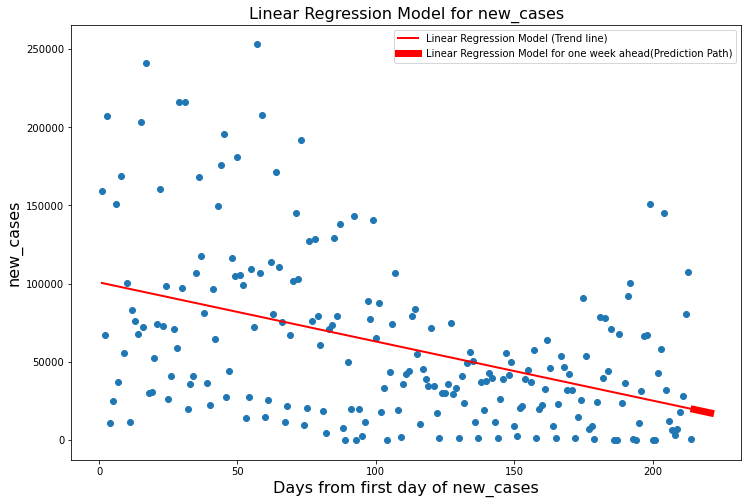

RMSE of Linear Regression on new_cases 48442.23155959759


In [9]:
usa_X_cases,usa_y_cases = linear_model(usa_data_cases,'first_day','new_cases')

Function which accepts the values obtained from the linear_model function, degree and the column name. It is used for predicting the trend line and prediction path for one week ahead using the polynomial regression model with different degress.

In [10]:
def non_linear_model(X,y,n,col2):
    for i in n:
        X_1 = X.ravel()
        y_1 = y.ravel()
        plt.figure(figsize=(12,8))
        #o = sns.regplot(X_1,y_1,color = 'red',label = 'Confidence Interval')
        plt.scatter(X,y)
        poly_reg = PolynomialFeatures(degree=i)
        X_poly = poly_reg.fit_transform(X)
        lin_reg2 = LinearRegression()
        lin_reg2.fit(X_poly,y) # Fitting the X and y values using the polynomial regression model with the respective degree
        pred1 = lin_reg2.predict(X_poly) # Predicting the values from the trained model
        X1 = np.arange(len(X)+1,len(X)+8).reshape(-1, 1) #getting the next 7 days
        X_poly1 = poly_reg.fit_transform(X1)
        pred2 = lin_reg2.predict(X_poly1) # Predicting the values for one week ahead days
        plt.plot(X, pred1 ,color = 'red',linewidth=2, label='(Trend line)Non Linear (Polynomial) Regression Model with degree '+str(i))
        plt.plot(X1, pred2 ,color = 'red',linewidth =7, label='(Prediction Path)Non Linear (Polynomial) Regression Model for one week ahead with degree '+str(i))
        plt.title('Non Linear (Polynomial) Regression Model with degree %d for '%i +col2,fontsize = 16)
        plt.xlabel('Days from first day of '+col2,fontsize=16)
        plt.ylabel(col2,fontsize=16)
        plt.legend()
        plt.show()
        print('One week ahead forecast using Non-linear Regression Model with degree %d'%i,pred2)
        #Calculating the root mean squared error by using the mean_squared_error function from sklearn.metrics
        rmse = sqrt(mean_squared_error(y,pred1))
        print('RMSE of Non Linear (Polynomial) Regression with degree %d on '%i +col2,rmse)
    return

Polynomial regression model for the new_cases across USA for the degrees 2 to 5

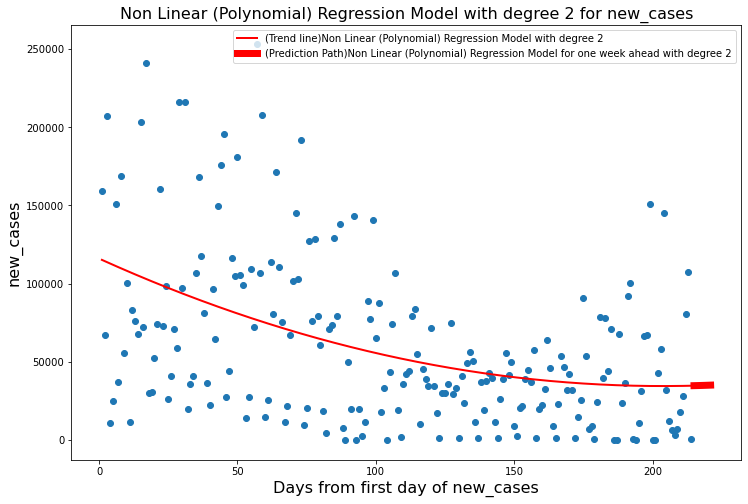

One week ahead forecast using Non-linear Regression Model with degree 2 [[34651.16292802]
 [34697.4804007 ]
 [34747.72680645]
 [34801.90214528]
 [34860.00641719]
 [34922.03962218]
 [34988.00176025]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 47975.931372924955


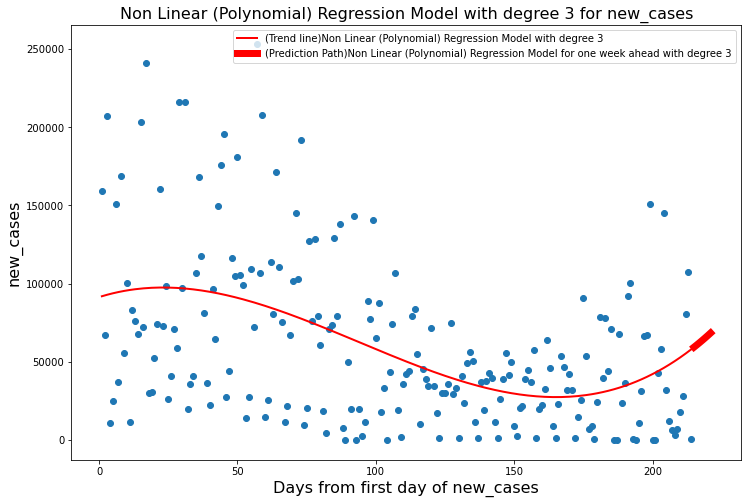

One week ahead forecast using Non-linear Regression Model with degree 3 [[59277.61844412]
 [60698.43575958]
 [62154.99913411]
 [63647.60181311]
 [65176.53704198]
 [66742.09806612]
 [68344.57813093]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 47114.51151060665


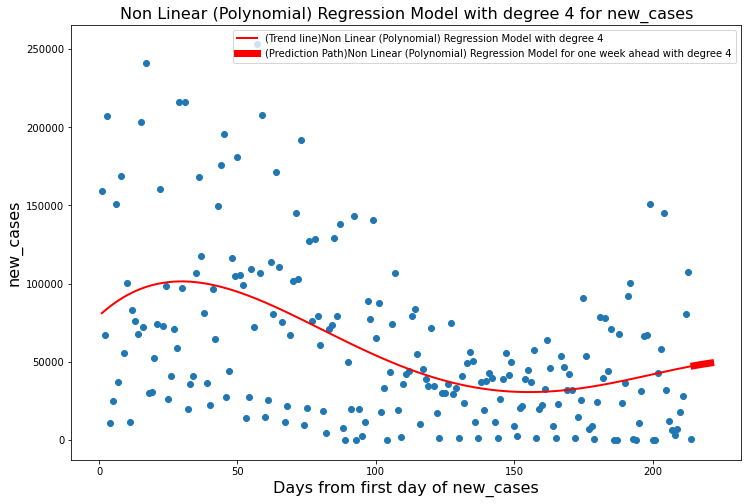

One week ahead forecast using Non-linear Regression Model with degree 4 [[47402.86972218]
 [47719.05923468]
 [48024.96864761]
 [48319.90139652]
 [48603.1518361 ]
 [48874.00524026]
 [49131.73780204]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 46962.83088865819


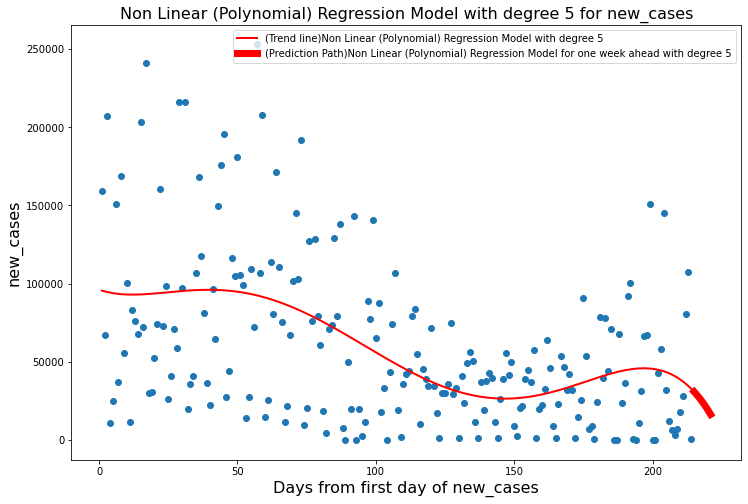

One week ahead forecast using Non-linear Regression Model with degree 5 [[30802.40618374]
 [28802.2511445 ]
 [26641.68254566]
 [24314.46894836]
 [21814.2555809 ]
 [19134.56329537]
 [16268.78752423]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 46730.42323778381


In [11]:
non_linear_model(usa_X_cases,usa_y_cases,[2,3,4,5],'new_cases')

In [12]:
usa_ind_deaths,usa_first_day_deaths = first_day_new_cases_deaths(usa_new_deaths_list)
usa_data_deaths = usa_data[['Dates','new_deaths']]
usa_data_deaths['first_day'] = usa_first_day_deaths
usa_data_deaths = usa_data_deaths.iloc[usa_ind_deaths:].reset_index(drop=True)
usa_data_deaths

,Dates,new_deaths,first_day
0,2022-06-01,483.0,1
1,2022-06-02,192.0,2
2,2022-06-03,219.0,3
3,2022-06-04,44.0,4
4,2022-06-05,0.0,5
...,...,...,...
209,2022-12-27,75.0,210
210,2022-12-28,217.0,211
211,2022-12-29,214.0,212
212,2022-12-30,1510.0,213


Linear regression model for new deaths across USA

One week ahead forecast using Linear Regression Model = [[237.64709754]
 [237.23316487]
 [236.81923219]
 [236.40529952]
 [235.99136685]
 [235.57743418]
 [235.1635015 ]]


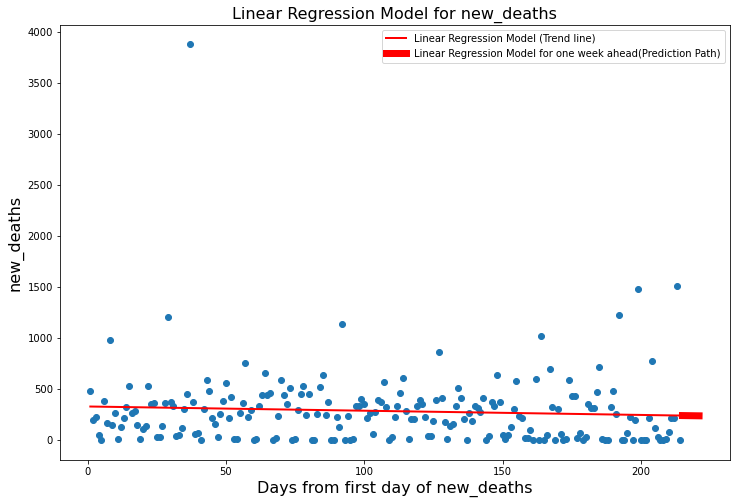

RMSE of Linear Regression on new_deaths 361.0230192808004


In [13]:
usa_X_deaths,usa_y_deaths = linear_model(usa_data_deaths,'first_day','new_deaths')

Polynomial regression model for the new_deaths across USA for the degrees 2 to 5

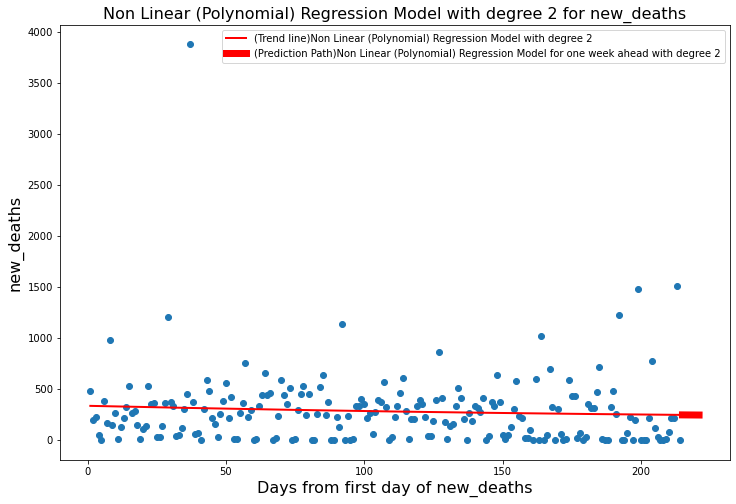

One week ahead forecast using Non-linear Regression Model with degree 2 [[244.28723106]
 [244.05860444]
 [243.83169361]
 [243.60649859]
 [243.38301936]
 [243.16125592]
 [242.94120828]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 361.01114385674805


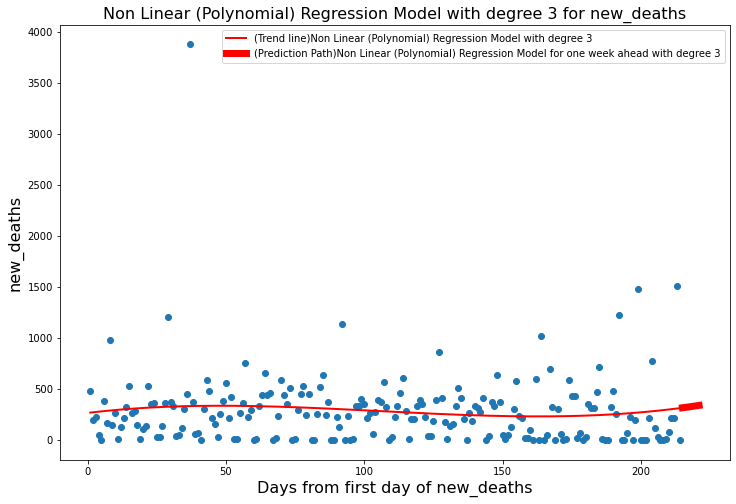

One week ahead forecast using Non-linear Regression Model with degree 3 [[313.97533356]
 [317.63627545]
 [321.38896945]
 [325.23424537]
 [329.17293306]
 [333.20586234]
 [337.33386303]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 360.10151947743867


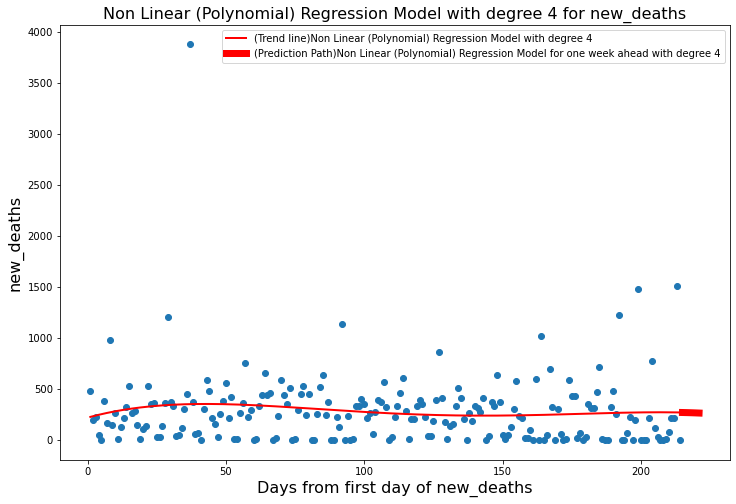

One week ahead forecast using Non-linear Regression Model with degree 4 [[267.6544957 ]
 [267.00652243]
 [266.27076312]
 [265.44418659]
 [264.52372618]
 [263.50627987]
 [262.38871016]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 359.7999092590437


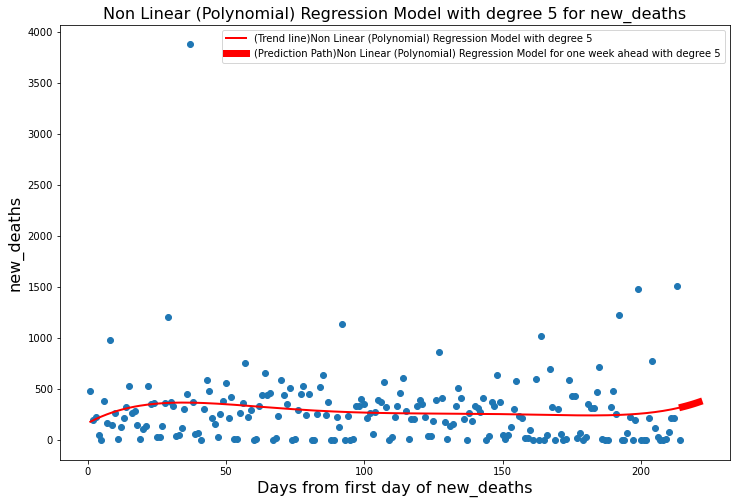

One week ahead forecast using Non-linear Regression Model with degree 5 [[322.15719621]
 [329.11432895]
 [336.47660015]
 [344.25915092]
 [352.47746211]
 [361.14735765]
 [370.28500804]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 359.47356777308124


In [14]:
non_linear_model(usa_X_deaths,usa_y_deaths,[2,3,4,5],'new_deaths')

Reading the owid_data_stage4 csv file generated in the stage2

In [15]:
owid_data = pd.read_csv('../../../data/Stage_2/owid_data_stage4.csv')
owid_data

,location,Dates,new_cases,new_deaths,new_cases_per_million,new_deaths_per_million,population
0,Indonesia,2022-05-30,218.0,12.0,0.791,0.044,275501344.0
1,Indonesia,2022-05-31,340.0,5.0,1.234,0.018,275501344.0
2,Indonesia,2022-06-01,368.0,3.0,1.336,0.011,275501344.0
3,Indonesia,2022-06-02,304.0,6.0,1.103,0.022,275501344.0
4,Indonesia,2022-06-03,372.0,4.0,1.350,0.015,275501344.0
...,...,...,...,...,...,...,...
649,Pakistan,2022-12-29,121.0,1.0,0.513,0.004,235824864.0
650,Pakistan,2022-12-30,0.0,0.0,0.000,0.000,235824864.0
651,Pakistan,2022-12-31,0.0,0.0,0.000,0.000,235824864.0
652,Pakistan,2023-01-01,45.0,0.0,0.191,0.000,235824864.0


In [16]:
#Selecting the range of dates from 31st May 2022 to Jan 1st 2023
owid_data = owid_data[(owid_data['Dates'] > '2022-05-31') & (owid_data['Dates'] < '2023-01-01')]
#Selecting the required columns
owid_data_1 = owid_data[['location','Dates','new_cases','new_deaths']].reset_index(drop=True)
owid_data_1

,location,Dates,new_cases,new_deaths
0,Indonesia,2022-06-01,368.0,3.0
1,Indonesia,2022-06-02,304.0,6.0
2,Indonesia,2022-06-03,372.0,4.0
3,Indonesia,2022-06-04,395.0,6.0
4,Indonesia,2022-06-05,388.0,5.0
...,...,...,...,...
637,Pakistan,2022-12-27,0.0,0.0
638,Pakistan,2022-12-28,0.0,0.0
639,Pakistan,2022-12-29,121.0,1.0
640,Pakistan,2022-12-30,0.0,0.0


In [17]:
#Separating the data of Indonesia location
indo_data = owid_data_1[owid_data_1['location']=='Indonesia'].reset_index(drop=True)
indo_data

,location,Dates,new_cases,new_deaths
0,Indonesia,2022-06-01,368.0,3.0
1,Indonesia,2022-06-02,304.0,6.0
2,Indonesia,2022-06-03,372.0,4.0
3,Indonesia,2022-06-04,395.0,6.0
4,Indonesia,2022-06-05,388.0,5.0
...,...,...,...,...
209,Indonesia,2022-12-27,803.0,9.0
210,Indonesia,2022-12-28,695.0,14.0
211,Indonesia,2022-12-29,685.0,9.0
212,Indonesia,2022-12-30,552.0,10.0


In [18]:
indo_new_cases_list = indo_data['new_cases'].tolist()
indo_new_deaths_list = indo_data['new_deaths'].tolist()

In [19]:
indo_ind_cases,indo_first_day_cases = first_day_new_cases_deaths(indo_new_cases_list)
indo_data_cases = indo_data[['Dates','new_cases']]
indo_data_cases['first_day'] = indo_first_day_cases
indo_data_cases = indo_data_cases.iloc[indo_ind_cases:].reset_index(drop=True)
indo_data_cases

,Dates,new_cases,first_day
0,2022-06-01,368.0,1
1,2022-06-02,304.0,2
2,2022-06-03,372.0,3
3,2022-06-04,395.0,4
4,2022-06-05,388.0,5
...,...,...,...
209,2022-12-27,803.0,210
210,2022-12-28,695.0,211
211,2022-12-29,685.0,212
212,2022-12-30,552.0,213


Linear regression model for new cases across Indonesia

One week ahead forecast using Linear Regression Model = [[3437.70646308]
 [3440.78523652]
 [3443.86400997]
 [3446.94278341]
 [3450.02155686]
 [3453.1003303 ]
 [3456.17910375]]


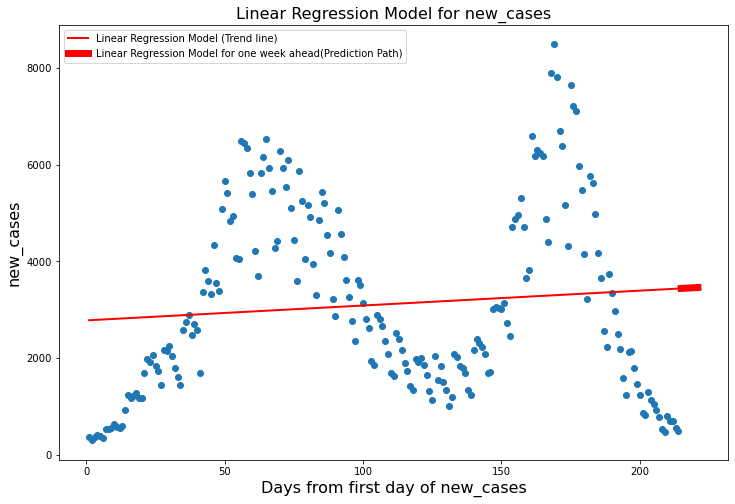

RMSE of Linear Regression on new_cases 1901.240100901625


In [20]:
indo_X_cases,indo_y_cases = linear_model(indo_data_cases,'first_day','new_cases')

Polynomial regression model for the new_cases across Indonesia for the degrees 2 to 5

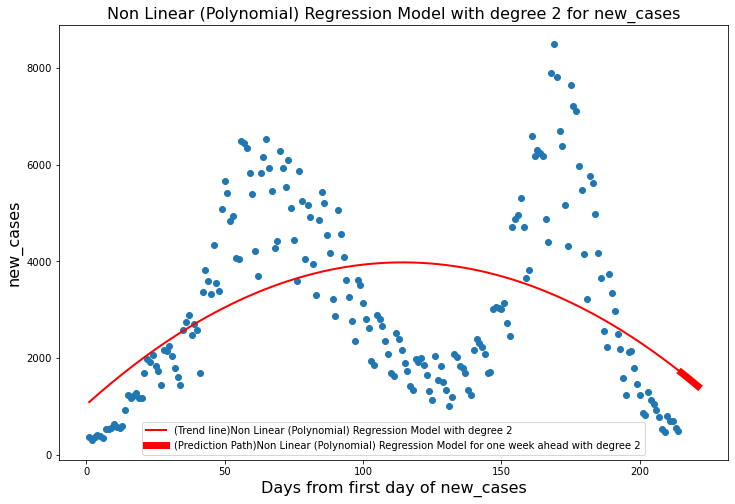

One week ahead forecast using Non-linear Regression Model with degree 2 [[1695.08645543]
 [1649.53397285]
 [1603.53120085]
 [1557.07813946]
 [1510.17478865]
 [1462.82114844]
 [1415.01721882]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 1739.0115716545006


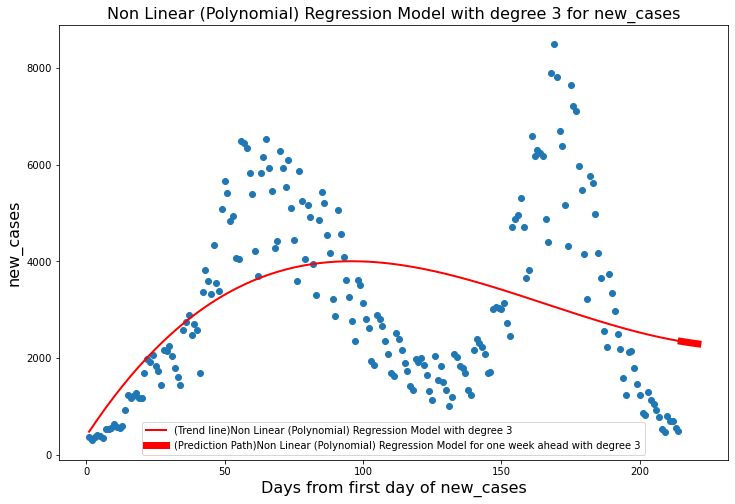

One week ahead forecast using Non-linear Regression Model with degree 3 [[2341.73066239]
 [2332.2699495 ]
 [2323.19440484]
 [2314.51172847]
 [2306.22962046]
 [2298.3557809 ]
 [2290.89790983]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 1722.6965267555518


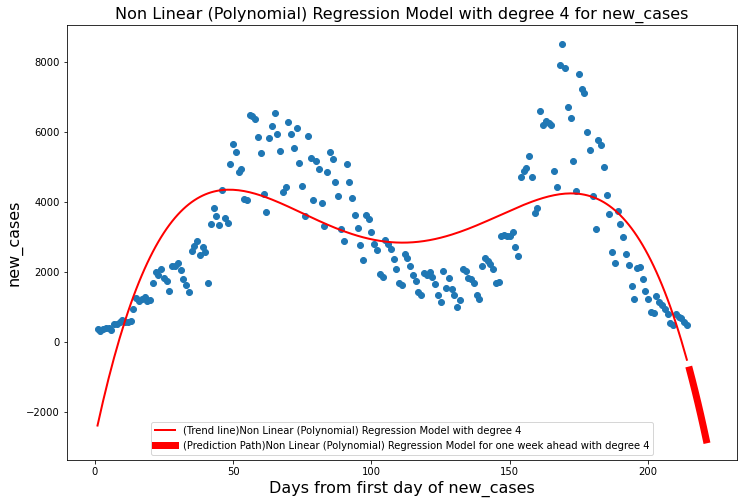

One week ahead forecast using Non-linear Regression Model with degree 4 [[ -805.06865732]
 [-1107.25488379]
 [-1421.25283841]
 [-1747.31711995]
 [-2085.70473359]
 [-2436.67509094]
 [-2800.49001   ]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 1401.9981528637072


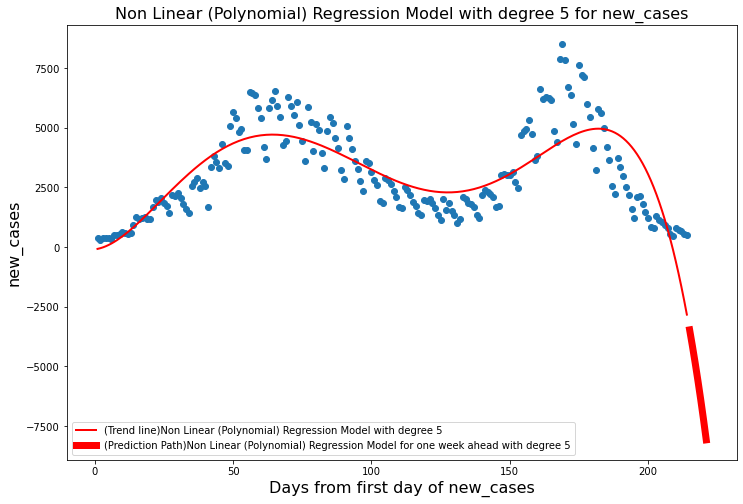

One week ahead forecast using Non-linear Regression Model with degree 5 [[-3469.80547315]
 [-4143.81537751]
 [-4853.73669206]
 [-5600.71248309]
 [-6385.90656325]
 [-7210.50365903]
 [-8075.7095782 ]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 1185.1229292368532


In [21]:
non_linear_model(indo_X_cases,indo_y_cases,[2,3,4,5],'new_cases')

In [22]:
indo_ind_deaths,indo_first_day_deaths = first_day_new_cases_deaths(indo_new_deaths_list)
indo_data_deaths = indo_data[['Dates','new_deaths']]
indo_data_deaths['first_day'] = indo_first_day_deaths
indo_data_deaths = indo_data_deaths.iloc[indo_ind_deaths:].reset_index(drop=True)
indo_data_deaths

,Dates,new_deaths,first_day
0,2022-06-01,3.0,1
1,2022-06-02,6.0,2
2,2022-06-03,4.0,3
3,2022-06-04,6.0,4
4,2022-06-05,5.0,5
...,...,...,...
209,2022-12-27,9.0,210
210,2022-12-28,14.0,211
211,2022-12-29,9.0,212
212,2022-12-30,10.0,213


Linear regression model for new deaths across Indonesia

One week ahead forecast using Linear Regression Model = [[33.84467553]
 [33.98472163]
 [34.12476773]
 [34.26481383]
 [34.40485994]
 [34.54490604]
 [34.68495214]]


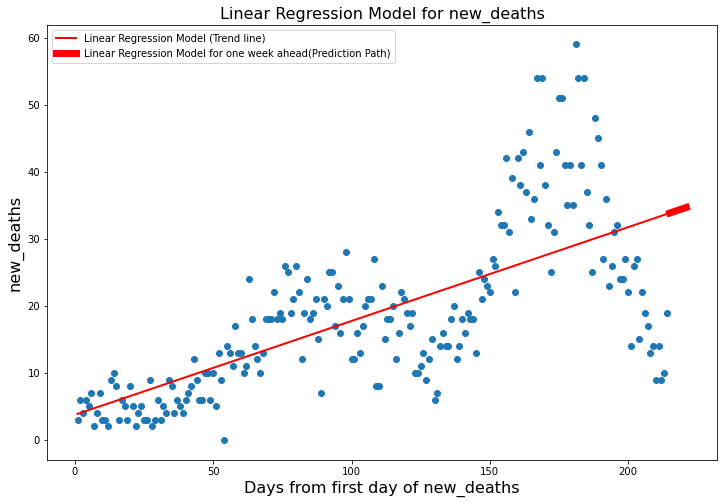

RMSE of Linear Regression on new_deaths 9.066760348240384


In [23]:
indo_X_deaths,indo_y_deaths = linear_model(indo_data_deaths,'first_day','new_deaths')

Polynomial regression model for the new_deaths across Indonesia for the degrees 2 to 5

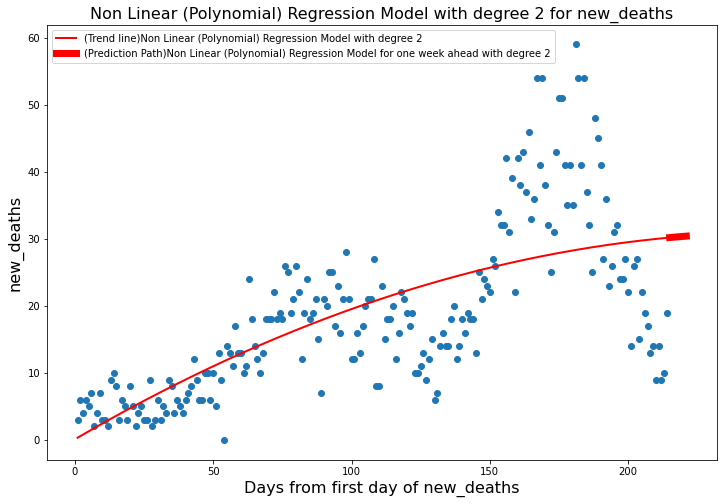

One week ahead forecast using Non-linear Regression Model with degree 2 [[30.18494515]
 [30.22285924]
 [30.25982766]
 [30.29585042]
 [30.33092751]
 [30.36505894]
 [30.39824469]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 8.921966199703327


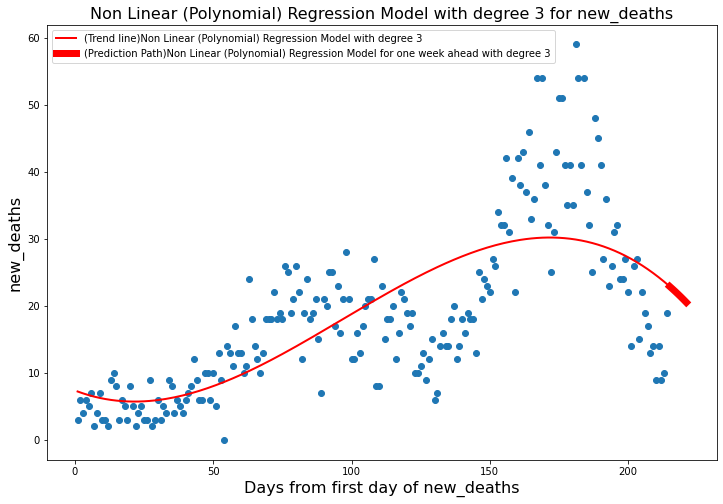

One week ahead forecast using Non-linear Regression Model with degree 3 [[22.88628476]
 [22.51683176]
 [22.1370033 ]
 [21.74671247]
 [21.34587235]
 [20.93439605]
 [20.51219664]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 8.50919642127228


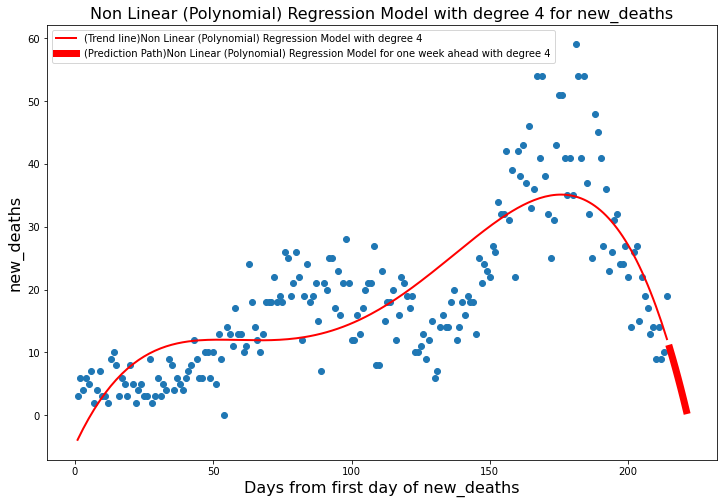

One week ahead forecast using Non-linear Regression Model with degree 4 [[10.6629638 ]
 [ 9.15645768]
 [ 7.59219889]
 [ 5.96908165]
 [ 4.28599083]
 [ 2.54180198]
 [ 0.73538126]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 7.568795840264292


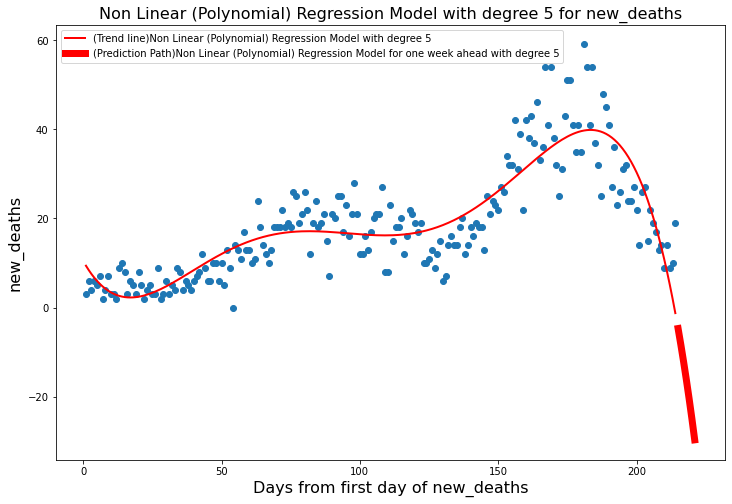

One week ahead forecast using Non-linear Regression Model with degree 5 [[ -4.66887192]
 [ -8.31471305]
 [-12.15696756]
 [-16.20185314]
 [-20.45570237]
 [-24.92496363]
 [-29.6162021 ]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 6.221930470724695


In [24]:
non_linear_model(indo_X_deaths,indo_y_deaths,[2,3,4,5],'new_deaths')

In [25]:
#Separting the data of Nigeria
ng_data = owid_data_1[owid_data_1['location']=='Nigeria'].reset_index(drop=True)
ng_data

,location,Dates,new_cases,new_deaths
0,Nigeria,2022-06-01,0.0,0.0
1,Nigeria,2022-06-02,85.0,0.0
2,Nigeria,2022-06-03,0.0,0.0
3,Nigeria,2022-06-04,35.0,0.0
4,Nigeria,2022-06-05,0.0,0.0
...,...,...,...,...
209,Nigeria,2022-12-27,0.0,0.0
210,Nigeria,2022-12-28,0.0,0.0
211,Nigeria,2022-12-29,0.0,0.0
212,Nigeria,2022-12-30,0.0,0.0


In [26]:
ng_new_cases_list = ng_data['new_cases'].tolist()
ng_new_deaths_list = ng_data['new_deaths'].tolist()

In [27]:
ng_ind_cases,ng_first_day_cases = first_day_new_cases_deaths(ng_new_cases_list)
ng_data_cases = ng_data[['Dates','new_cases']]
ng_data_cases['first_day'] = ng_first_day_cases
ng_data_cases = ng_data_cases.iloc[ng_ind_cases:].reset_index(drop=True)
ng_data_cases

,Dates,new_cases,first_day
0,2022-06-02,85.0,1
1,2022-06-03,0.0,2
2,2022-06-04,35.0,3
3,2022-06-05,0.0,4
4,2022-06-06,0.0,5
...,...,...,...
208,2022-12-27,0.0,209
209,2022-12-28,0.0,210
210,2022-12-29,0.0,211
211,2022-12-30,0.0,212


Linear regression model for new cases across Nigeria

One week ahead forecast using Linear Regression Model = [[-3.75099655]
 [-4.24031085]
 [-4.72962515]
 [-5.21893945]
 [-5.70825375]
 [-6.19756806]
 [-6.68688236]]


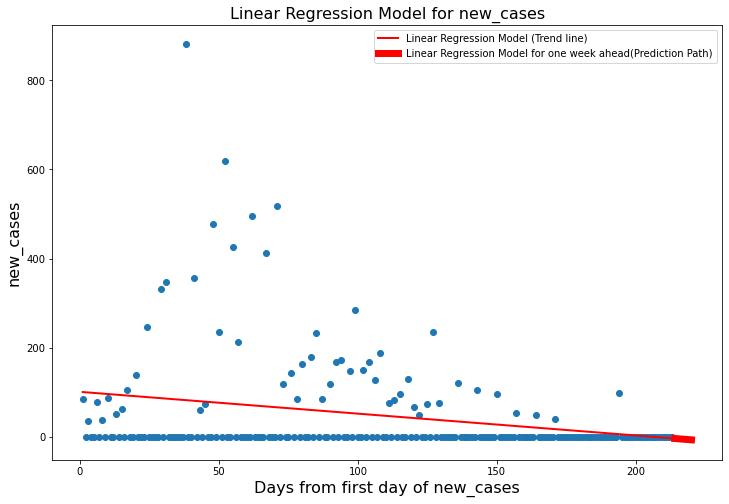

RMSE of Linear Regression on new_cases 113.53730794274986


In [28]:
ng_X_cases,ng_y_cases = linear_model(ng_data_cases,'first_day','new_cases')

Polynomial regression model for new_cases across across Indonesia for degree 2 to 5

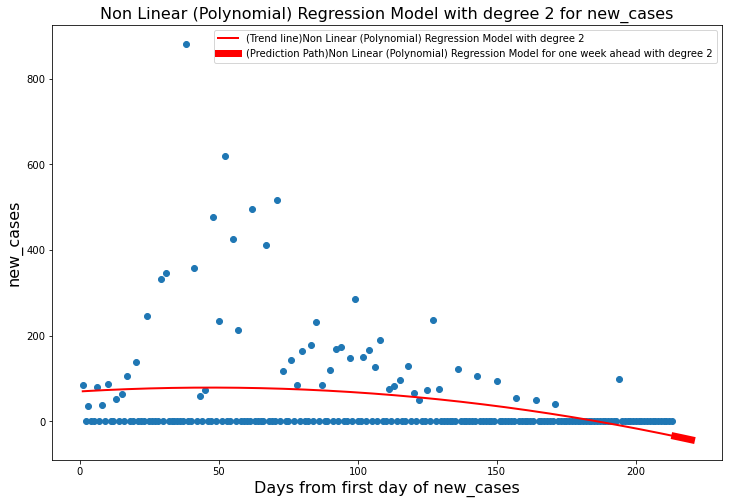

One week ahead forecast using Non-linear Regression Model with degree 2 [[-34.99991814]
 [-36.36537043]
 [-37.73897284]
 [-39.12072537]
 [-40.51062802]
 [-41.9086808 ]
 [-43.31488369]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 112.69803020347341


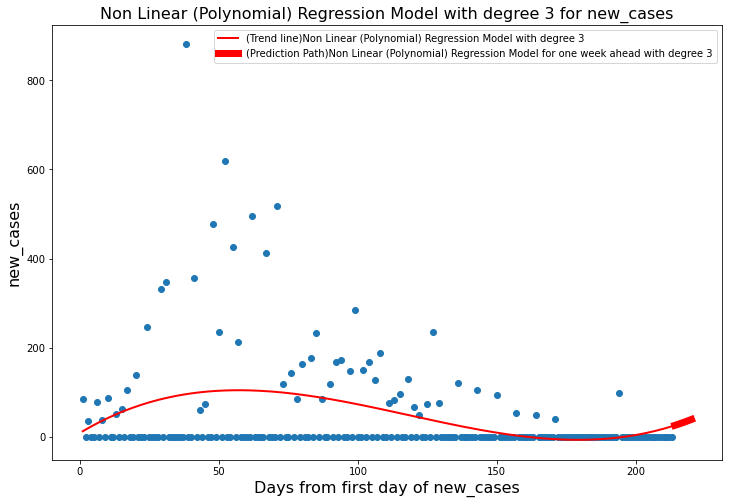

One week ahead forecast using Non-linear Regression Model with degree 3 [[25.79319465]
 [27.83670195]
 [29.95133727]
 [32.13783465]
 [34.39692815]
 [36.72935183]
 [39.13583975]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 110.46174893631874


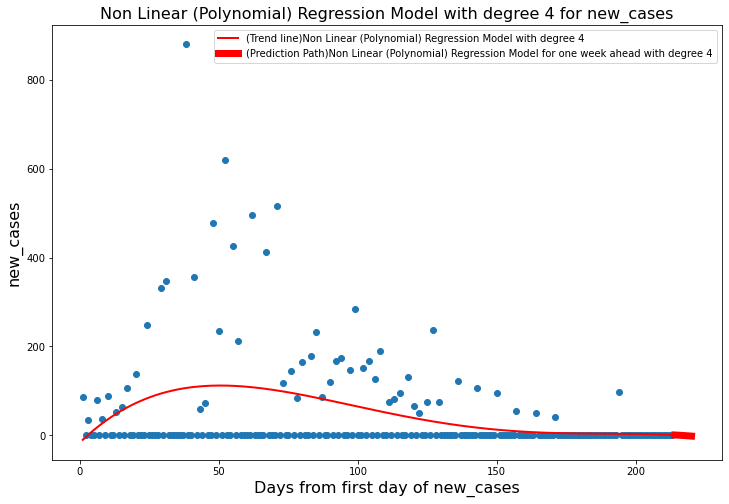

One week ahead forecast using Non-linear Regression Model with degree 4 [[ 0.31579644]
 [-0.02176154]
 [-0.38786401]
 [-0.78393034]
 [-1.21139973]
 [-1.67173123]
 [-2.16640376]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 110.16415139460786


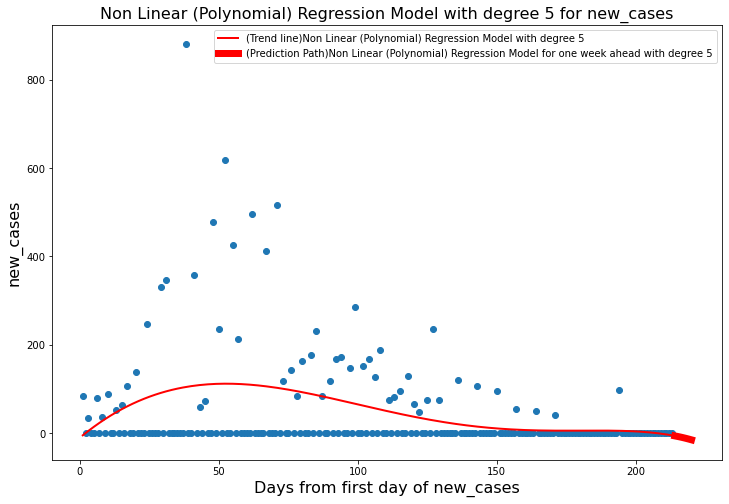

One week ahead forecast using Non-linear Regression Model with degree 5 [[ -6.20829081]
 [ -7.46043034]
 [ -8.80066829]
 [-10.23262975]
 [-11.76000535]
 [-13.38655175]
 [-15.11609204]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 110.14889636025761


In [29]:
non_linear_model(ng_X_cases,ng_y_cases,[2,3,4,5],'new_cases')

In [30]:
ng_ind_deaths,ng_first_day_deaths = first_day_new_cases_deaths(ng_new_deaths_list)
ng_data_deaths = ng_data[['Dates','new_deaths']]
ng_data_deaths['first_day'] = ng_first_day_deaths
ng_data_deaths = ng_data_deaths.iloc[ng_ind_deaths:].reset_index(drop=True)
ng_data_deaths

,Dates,new_deaths,first_day
0,2022-06-06,5.0,1
1,2022-06-07,0.0,2
2,2022-06-08,0.0,3
3,2022-06-09,0.0,4
4,2022-06-10,0.0,5
...,...,...,...
204,2022-12-27,0.0,205
205,2022-12-28,0.0,206
206,2022-12-29,0.0,207
207,2022-12-30,0.0,208


Linear regression model for new deaths across Nigeria

One week ahead forecast using Linear Regression Model = [[-0.03248068]
 [-0.03351911]
 [-0.03455755]
 [-0.03559598]
 [-0.03663442]
 [-0.03767285]
 [-0.03871129]]


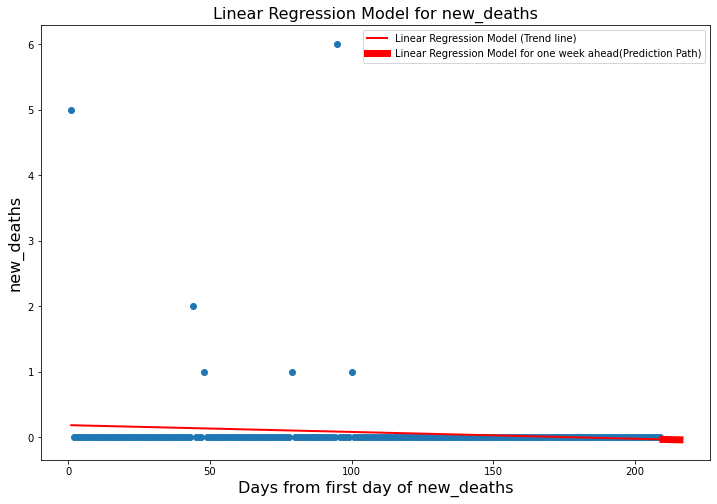

RMSE of Linear Regression on new_deaths 0.5617588398213609


In [31]:
ng_X_deaths,ng_y_deaths = linear_model(ng_data_deaths,'first_day','new_deaths')

Polynomial regression model for new deaths across Nigeria for degree 2 to 5

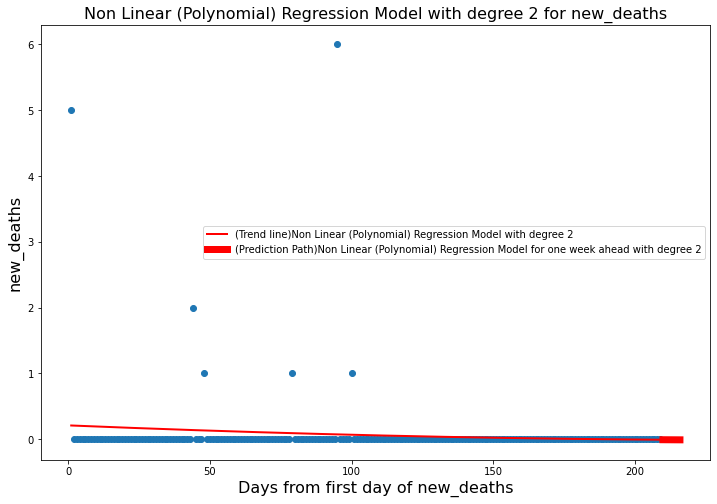

One week ahead forecast using Non-linear Regression Model with degree 2 [[-0.00637025]
 [-0.00666267]
 [-0.00694803]
 [-0.00722631]
 [-0.00749752]
 [-0.00776165]
 [-0.00801872]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 0.561640901337481


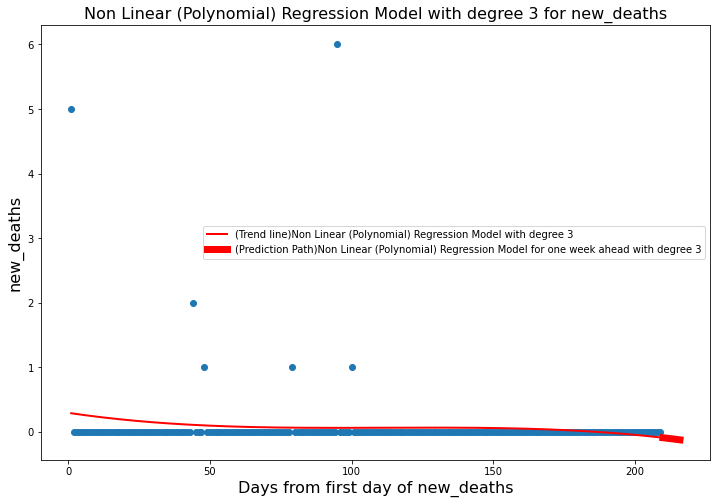

One week ahead forecast using Non-linear Regression Model with degree 3 [[-0.0902958 ]
 [-0.09538397]
 [-0.10057871]
 [-0.10588109]
 [-0.11129219]
 [-0.11681308]
 [-0.12244483]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 0.5607944689393826


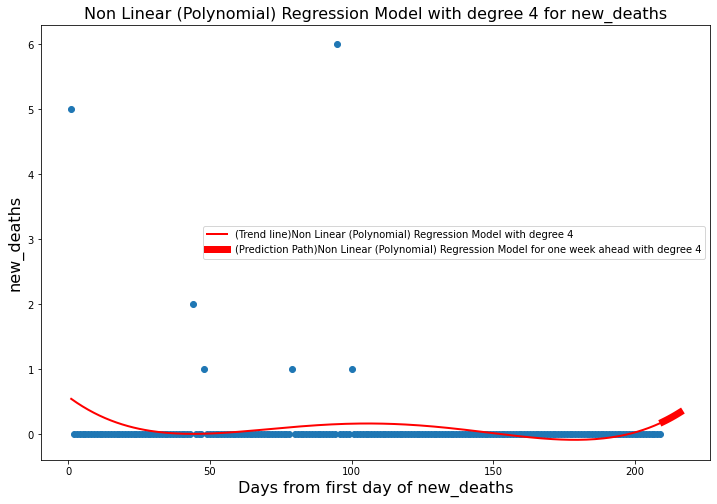

One week ahead forecast using Non-linear Regression Model with degree 4 [[0.18957179]
 [0.21113768]
 [0.23373389]
 [0.2573844 ]
 [0.28211337]
 [0.30794525]
 [0.33490468]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 0.5536983155495057


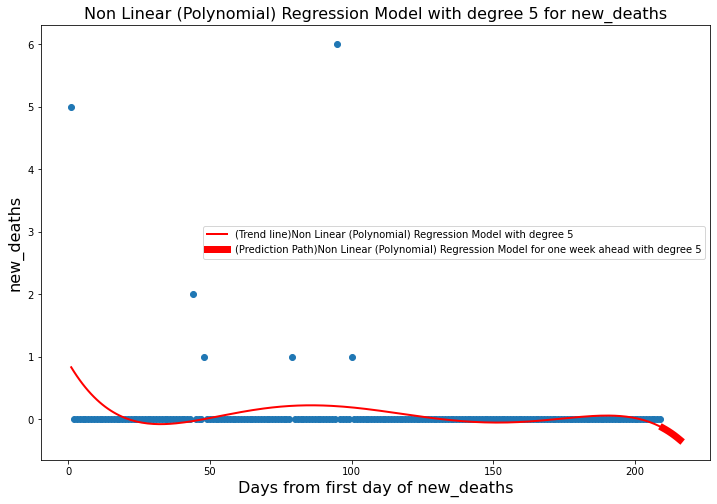

One week ahead forecast using Non-linear Regression Model with degree 5 [[-0.14242892]
 [-0.16829179]
 [-0.19627127]
 [-0.22646214]
 [-0.25896149]
 [-0.29386868]
 [-0.3312854 ]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 0.5458034254893029


In [32]:
non_linear_model(ng_X_deaths,ng_y_deaths,[2,3,4,5],'new_deaths')

In [33]:
#Separating the data of Pakistan location
pak_data = owid_data_1[owid_data_1['location']=='Pakistan'].reset_index(drop=True)
pak_data

,location,Dates,new_cases,new_deaths
0,Pakistan,2022-06-01,67.0,0.0
1,Pakistan,2022-06-02,36.0,0.0
2,Pakistan,2022-06-03,0.0,0.0
3,Pakistan,2022-06-04,0.0,0.0
4,Pakistan,2022-06-05,208.0,0.0
...,...,...,...,...
209,Pakistan,2022-12-27,0.0,0.0
210,Pakistan,2022-12-28,0.0,0.0
211,Pakistan,2022-12-29,121.0,1.0
212,Pakistan,2022-12-30,0.0,0.0


In [34]:
pak_new_cases_list = pak_data['new_cases'].tolist()
pak_new_deaths_list = pak_data['new_deaths'].tolist()

In [35]:
pak_ind_cases,pak_first_day_cases = first_day_new_cases_deaths(pak_new_cases_list)
pak_data_cases = pak_data[['Dates','new_cases']]
pak_data_cases['first_day'] = pak_first_day_cases
pak_data_cases = pak_data_cases.iloc[pak_ind_cases:].reset_index(drop=True)
pak_data_cases

,Dates,new_cases,first_day
0,2022-06-01,67.0,1
1,2022-06-02,36.0,2
2,2022-06-03,0.0,3
3,2022-06-04,0.0,4
4,2022-06-05,208.0,5
...,...,...,...
209,2022-12-27,0.0,210
210,2022-12-28,0.0,211
211,2022-12-29,121.0,212
212,2022-12-30,0.0,213


Linear regression model for new casess across Pakistan

One week ahead forecast using Linear Regression Model = [[-46.61708569]
 [-49.02069605]
 [-51.42430641]
 [-53.82791677]
 [-56.23152713]
 [-58.63513749]
 [-61.03874785]]


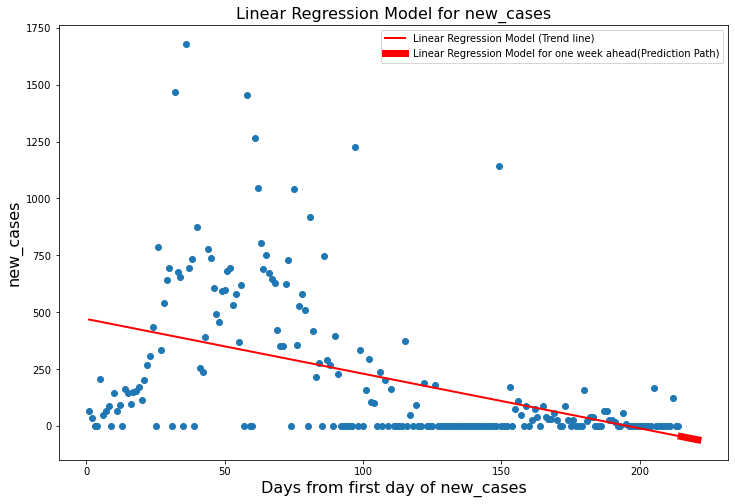

RMSE of Linear Regression on new_cases 287.843090167427


In [36]:
pak_X_cases,pak_y_cases = linear_model(pak_data_cases,'first_day','new_cases')

Polynomial regression model for new cases across Pakistan for degree 2 to 5

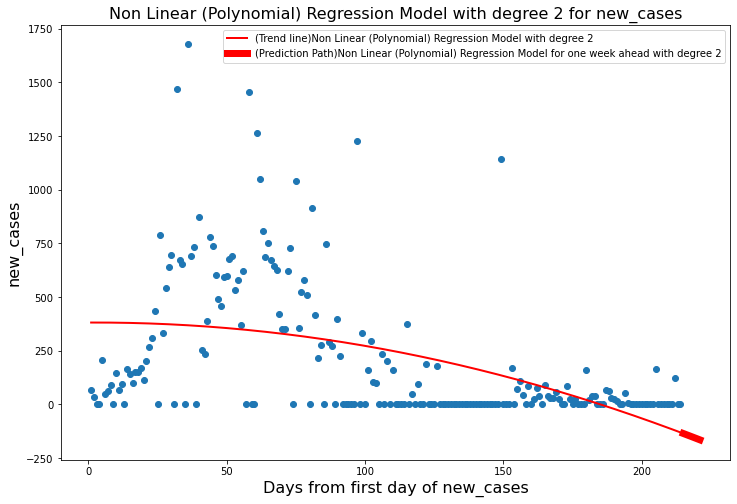

One week ahead forecast using Non-linear Regression Model with degree 2 [[-135.28462079]
 [-140.16267399]
 [-145.0636387 ]
 [-149.98751492]
 [-154.93430264]
 [-159.90400187]
 [-164.89661261]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_cases 285.17491553272765


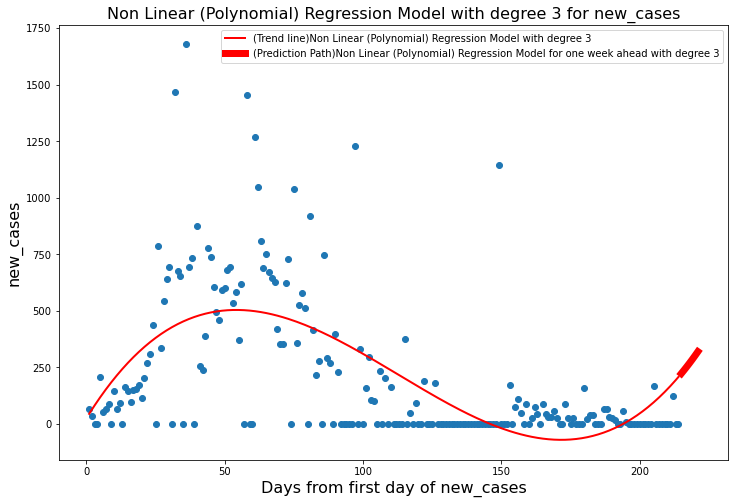

One week ahead forecast using Non-linear Regression Model with degree 3 [[221.86675887]
 [236.92273616]
 [252.41723784]
 [268.35451676]
 [284.7388258 ]
 [301.57441782]
 [318.86554568]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_cases 253.17193539485368


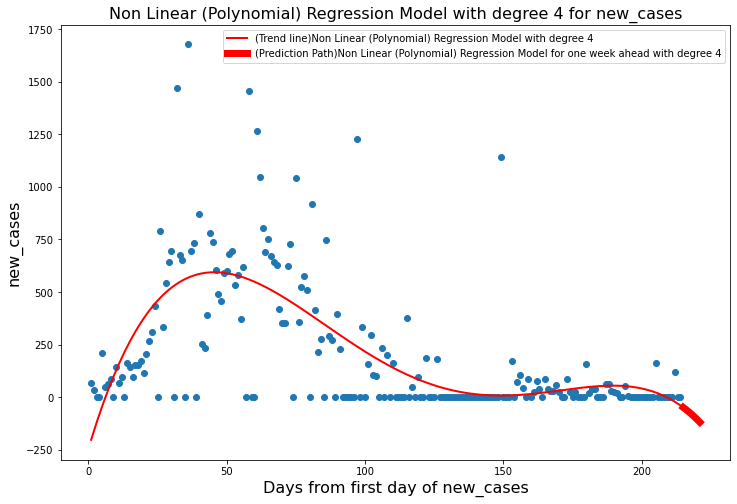

One week ahead forecast using Non-linear Regression Model with degree 4 [[ -48.63171617]
 [ -58.73838687]
 [ -69.45497684]
 [ -80.79978041]
 [ -92.79129872]
 [-105.4482398 ]
 [-118.78951853]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_cases 238.0998248072289


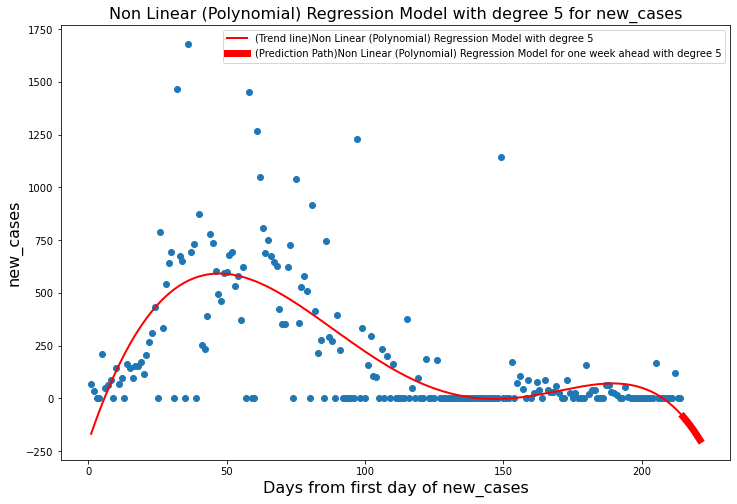

One week ahead forecast using Non-linear Regression Model with degree 5 [[ -88.05776305]
 [-103.66542318]
 [-120.23954435]
 [-137.81156522]
 [-156.41340265]
 [-176.07745417]
 [-196.83660042]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_cases 237.84179724725666


In [37]:
non_linear_model(pak_X_cases,pak_y_cases,[2,3,4,5],'new_cases')

In [38]:
pak_ind_deaths,pak_first_day_deaths = first_day_new_cases_deaths(pak_new_deaths_list)
pak_data_deaths = pak_data[['Dates','new_deaths']]
pak_data_deaths['first_day'] = pak_first_day_deaths
pak_data_deaths = pak_data_deaths.iloc[pak_ind_deaths:].reset_index(drop=True)
pak_data_deaths

,Dates,new_deaths,first_day
0,2022-06-10,2.0,1
1,2022-06-11,0.0,2
2,2022-06-12,0.0,3
3,2022-06-13,0.0,4
4,2022-06-14,0.0,5
...,...,...,...
200,2022-12-27,0.0,201
201,2022-12-28,0.0,202
202,2022-12-29,1.0,203
203,2022-12-30,0.0,204


Linear regression model for new deaths across Pakistan

One week ahead forecast using Linear Regression Model = [[-0.19210904]
 [-0.20614562]
 [-0.2201822 ]
 [-0.23421877]
 [-0.24825535]
 [-0.26229193]
 [-0.27632851]]


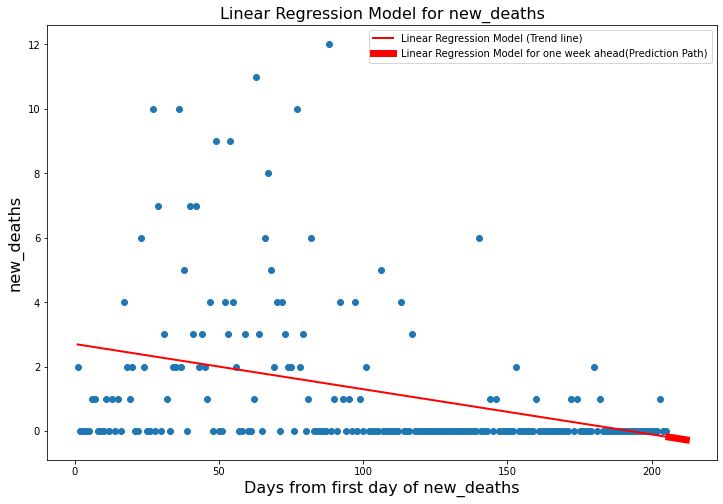

RMSE of Linear Regression on new_deaths 2.2167468534843815


In [39]:
pak_X_deaths,pak_y_deaths = linear_model(pak_data_deaths,'first_day','new_deaths')

Polynomial regression model for new deaths across Pakistan for degree 2 to 5

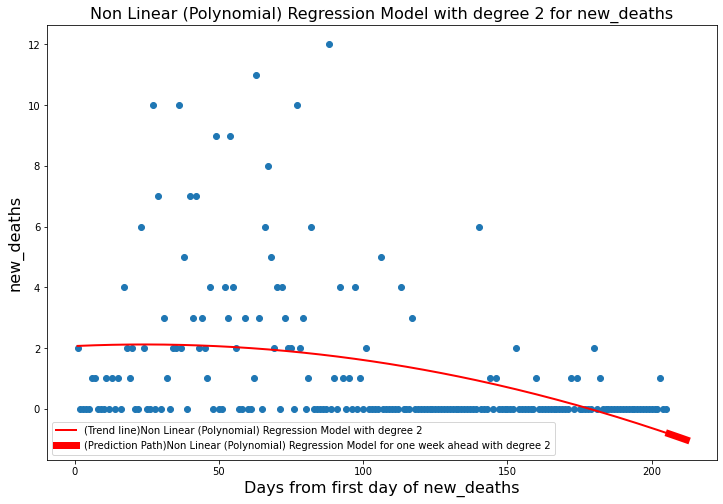

One week ahead forecast using Non-linear Regression Model with degree 2 [[-0.82509276]
 [-0.85756576]
 [-0.89021689]
 [-0.92304614]
 [-0.95605353]
 [-0.98923905]
 [-1.02260269]]
RMSE of Non Linear (Polynomial) Regression with degree 2 on new_deaths 2.1991235466974466


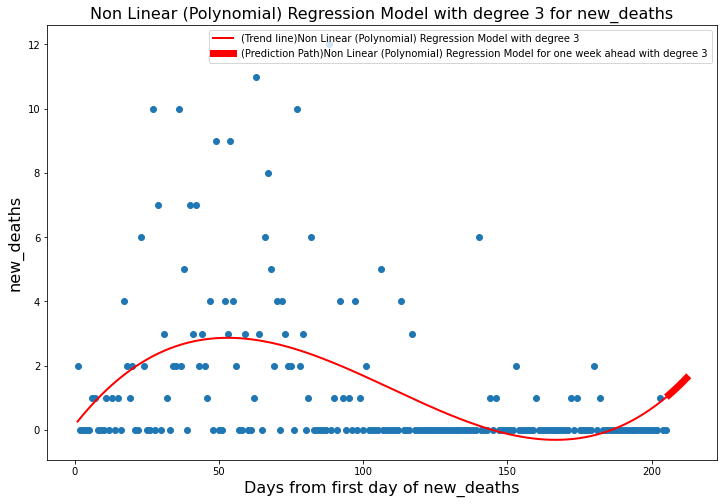

One week ahead forecast using Non-linear Regression Model with degree 3 [[1.09343423]
 [1.17272009]
 [1.25452731]
 [1.33888184]
 [1.42580964]
 [1.51533668]
 [1.6074889 ]]
RMSE of Non Linear (Polynomial) Regression with degree 3 on new_deaths 2.0833197381983237


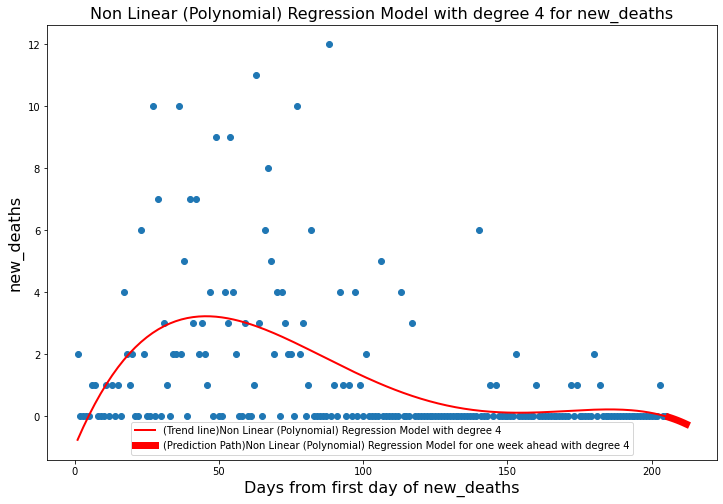

One week ahead forecast using Non-linear Regression Model with degree 4 [[-0.03896913]
 [-0.06962534]
 [-0.10254029]
 [-0.13779526]
 [-0.17547256]
 [-0.21565554]
 [-0.25842857]]
RMSE of Non Linear (Polynomial) Regression with degree 4 on new_deaths 2.052068302460229


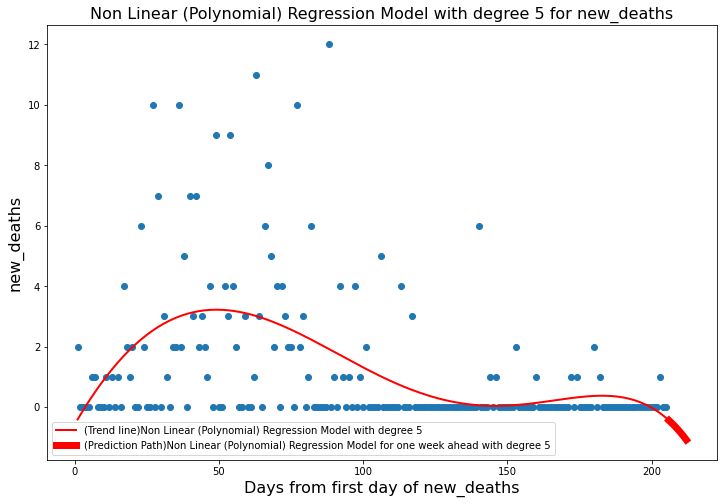

One week ahead forecast using Non-linear Regression Model with degree 5 [[-0.44763026]
 [-0.53779953]
 [-0.63425255]
 [-0.73722544]
 [-0.84695863]
 [-0.96369699]
 [-1.08768978]]
RMSE of Non Linear (Polynomial) Regression with degree 5 on new_deaths 2.0488703337176166


In [40]:
non_linear_model(pak_X_deaths,pak_y_deaths,[2,3,4,5],'new_deaths')

#### Bias vs Variance

- Generally this Bias vs variance tradeoff will give us information about prediction errors and helps to find out model accuracy.

- We can have better understanding regarding the underfitting and overfitting problems.

By default the linear regression model is highly biased and has low variance. With increasing the degree of polynomial regression the bias will be reduced and the variance will start increasing. For higher degrees we can observe the overfitting problem. 

So if we need to select a model which is best then we need to select the model which has moderate bias and moderate variance.

If we observe the linear regression model predicted trend line the root mean squared error is high. As the degree of polynomial regression model is increased the root mean squared error will keep on reducing. 

For the USA data the best model predicted trend line for new cases can be for polynomial regression model with degree 3 

References:

- https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe

- https://stackoverflow.com/questions/41328922/python-pandas-simple-example-of-calculating-rmse-from-data-frame

- https://stackoverflow.com/questions/64998713/i-want-to-delete-specific-dates-from-a-column-in-pandas

- https://www.analyticsvidhya.com/blog/2020/03/polynomial-regression-python/

- https://www.askpython.com/python/examples/polynomial-regression-in-python